In [1]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
import pymorphy2
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

from utils.data_transformation import remove_stop_words
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
# stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
# 0) Firstly, run tf_idf_for_subdialogs.ipynb to get subdialog_keywords.csv file
df = pd.read_csv(os.path.join("data", "processed_dialog_files", "subdialog_keywords.csv"))

In [3]:
# DO NOT delete this part, because it is a method to use jsons for this code!!!!!!!!!

# # Import Dataset
# path_to_articles = '../static/ukr_articles'
# data = pd.read_csv(path_to_articles, sep = ';', header = None)
#
# LANGUAGE = "ua"
# stop_words = remove_stop_words(data, LANGUAGE, "get_stop_words")
#
# # write your number of rows to analyse. max == 695,
# # but to clean and analyse 30 rows is spending 6 minutes
# df = pd.DataFrame(data[:20])
#
# df.columns = ["id", "title", "en_title", "content", "date", "source_url",
#                   "article_url"]
# # df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
# # print(df.target_names.unique())
# df.head()


In [8]:
# Convert to list
data = df.doc.values.tolist()

# # Remove Emails
# data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
#
# # Remove new line characters
# data = [re.sub('\s+', ' ', sent) for sent in data]
#
# # Remove distracting single quotes
# data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])


[' Наступного місяця бо зараз там якісь зміни в управлінні і не проводять '
 'іспити  Добре ти правий так і зробимо Привіт  Коли у тебе до речі по водінню '
 'іспит  Ти п яте ще не робив  Щоб пошвидше Просто потрібно спочатку скинути '
 'йому щоб він переглянув а потім уже будемо додаткові робити Привіт Діма ти '
 'може бенчмарк поки можеш не добавляти або у окрему гілку якусь написати '
 'активно займатися лаба річ частково зробити твій функція масив гіт закидати '
 'ятий завдання зробити привіт функція зчитування частково привіт діма '
 'завдання зробити треба робити сподіватися понеділок мати готово завтра '
 'допрацьовувати пушнути окий окойа спокійно дивитися тепер дуже добре '
 'розбиратися працювати дати безкоштовно радий пропасти страх код аха форма '
 'заповнити тип студент страшно написати viva64 com більший кількість помилка '
 'вказувати скачати pvc валгрінор пройтися зробити справа перший лаба треба '
 'зробити тобто код інший модуль запуститися змогти використати порівнян

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['наступного', 'місяця', 'бо', 'зараз', 'там', 'якісь', 'зміни', 'управлінні', 'не', 'проводять', 'іспити', 'добре', 'ти', 'правии', 'так', 'зробимо', 'привіт', 'коли', 'тебе', 'до', 'речі', 'по', 'водінню', 'іспит', 'ти', 'яте', 'ще', 'не', 'робив', 'щоб', 'пошвидше', 'просто', 'потрібно', 'спочатку', 'скинути', 'иому', 'щоб', 'він', 'переглянув', 'потім', 'уже', 'будемо', 'додаткові', 'робити', 'привіт', 'діма', 'ти', 'може', 'бенчмарк', 'поки', 'можеш', 'не', 'добавляти', 'або', 'окрему', 'гілку', 'якусь', 'написати', 'активно', 'заиматися', 'лаба', 'річ', 'частково', 'зробити', 'твіи', 'функція', 'масив', 'гіт', 'закидати', 'ятии', 'завдання', 'зробити', 'привіт', 'функція', 'зчитування', 'частково', 'привіт', 'діма', 'завдання', 'зробити', 'треба', 'робити', 'сподіватися', 'понеділок', 'мати', 'готово', 'завтра', 'допрацьовувати', 'пушнути', 'окии', 'окоиа', 'спокіино', 'дивитися', 'тепер', 'дуже', 'добре', 'розбиратися', 'працювати', 'дати', 'безкоштовно', 'радии', 'пропасти', '

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['наступного', 'місяця', 'бо', 'зараз', 'там', 'якісь', 'зміни', 'управлінні', 'не', 'проводять', 'іспити', 'добре', 'ти', 'правии', 'так', 'зробимо', 'привіт', 'коли', 'тебе', 'до', 'речі', 'по', 'водінню', 'іспит', 'ти', 'яте', 'ще', 'не', 'робив', 'щоб', 'пошвидше', 'просто', 'потрібно', 'спочатку', 'скинути', 'иому', 'щоб', 'він', 'переглянув', 'потім', 'уже', 'будемо', 'додаткові', 'робити', 'привіт_діма', 'ти', 'може', 'бенчмарк', 'поки', 'можеш', 'не', 'добавляти', 'або', 'окрему', 'гілку', 'якусь', 'написати', 'активно', 'заиматися', 'лаба', 'річ', 'частково', 'зробити', 'твіи', 'функція', 'масив', 'гіт', 'закидати', 'ятии', 'завдання', 'зробити', 'привіт', 'функція', 'зчитування', 'частково', 'привіт_діма', 'завдання', 'зробити', 'треба', 'робити', 'сподіватися', 'понеділок', 'мати', 'готово', 'завтра', 'допрацьовувати', 'пушнути', 'окии', 'окоиа', 'спокіино', 'дивитися', 'тепер', 'дуже', 'добре', 'розбиратися', 'працювати', 'дати', 'безкоштовно', 'радии', 'пропасти', 'страх',

In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent))
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

def lemmatization(data, lang, cube):
    """

    :param lang: "ru", "ua" or "en"
    :param cube: only for "ua"an object after these commands cube = Cube(verbose=True); cube.load("uk")
    :return: cleaned text from synonyms
    """
    lemmas = []
    for i in range(len(data)):
        data[i] = " ".join(data[i])

    data = ". ".join(data)

    if lang == "ru":
        lemmas = " ".join(pymorphy2.MorphAnalyzer().parse(np.unicode(word))[0].normal_form for word in msg.split())

    elif lang in ("ua", "en"):
        sentences = cube(data)

        for sentence in sentences:  # note we selected the first sentence (sentence[0])
            sentence_lemma = []
            for entry in sentence:
                sentence_lemma.append(entry.lemma)

            lemmas.append(sentence_lemma)

    return lemmas

In [12]:
from cube.api import Cube

# Remove Stop Words
# data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)
print(data_words_bigrams)

# If you have unlemmatized text data, so uncomment it !!!!!

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# # python3 -m spacy download en
# # nlp = spacy.load('en', disable=['parser', 'ner'])
# nlp = spacy.load('en_core_web_sm')
# # cube = Cube(verbose=True)
# # cube.load("en")
#

# Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams)
# data_lemmatized = lemmatization(data_words_bigrams[:20], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


# cube = ""
# if LANGUAGE == "ua":
#     cube = Cube(verbose=True)
#     cube.load("uk")
#
# elif LANGUAGE == "en":
#     cube = Cube(verbose=True)
#     cube.load("en")

# data_lemmatized = lemmatization(data_words_bigrams, LANGUAGE, cube)
data_lemmatized = data_words_bigrams


[['наступного', 'місяця', 'бо', 'зараз', 'там', 'якісь', 'зміни', 'управлінні', 'не', 'проводять', 'іспити', 'добре', 'ти', 'правии', 'так', 'зробимо', 'привіт', 'коли', 'тебе', 'до', 'речі', 'по', 'водінню', 'іспит', 'ти', 'яте', 'ще', 'не', 'робив', 'щоб', 'пошвидше', 'просто', 'потрібно', 'спочатку', 'скинути', 'иому', 'щоб', 'він', 'переглянув', 'потім', 'уже', 'будемо', 'додаткові', 'робити', 'привіт_діма', 'ти', 'може', 'бенчмарк', 'поки', 'можеш', 'не', 'добавляти', 'або', 'окрему', 'гілку', 'якусь', 'написати', 'активно', 'заиматися', 'лаба', 'річ', 'частково', 'зробити', 'твіи', 'функція', 'масив', 'гіт', 'закидати', 'ятии', 'завдання', 'зробити', 'привіт', 'функція', 'зчитування', 'частково', 'привіт_діма', 'завдання', 'зробити', 'треба', 'робити', 'сподіватися', 'понеділок', 'мати', 'готово', 'завтра', 'допрацьовувати', 'пушнути', 'окии', 'окоиа', 'спокіино', 'дивитися', 'тепер', 'дуже', 'добре', 'розбиратися', 'працювати', 'дати', 'безкоштовно', 'радии', 'пропасти', 'страх'

In [13]:
print(data_lemmatized[:1])
 # Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[['наступного', 'місяця', 'бо', 'зараз', 'там', 'якісь', 'зміни', 'управлінні', 'не', 'проводять', 'іспити', 'добре', 'ти', 'правии', 'так', 'зробимо', 'привіт', 'коли', 'тебе', 'до', 'речі', 'по', 'водінню', 'іспит', 'ти', 'яте', 'ще', 'не', 'робив', 'щоб', 'пошвидше', 'просто', 'потрібно', 'спочатку', 'скинути', 'иому', 'щоб', 'він', 'переглянув', 'потім', 'уже', 'будемо', 'додаткові', 'робити', 'привіт_діма', 'ти', 'може', 'бенчмарк', 'поки', 'можеш', 'не', 'добавляти', 'або', 'окрему', 'гілку', 'якусь', 'написати', 'активно', 'заиматися', 'лаба', 'річ', 'частково', 'зробити', 'твіи', 'функція', 'масив', 'гіт', 'закидати', 'ятии', 'завдання', 'зробити', 'привіт', 'функція', 'зчитування', 'частково', 'привіт_діма', 'завдання', 'зробити', 'треба', 'робити', 'сподіватися', 'понеділок', 'мати', 'готово', 'завтра', 'допрацьовувати', 'пушнути', 'окии', 'окоиа', 'спокіино', 'дивитися', 'тепер', 'дуже', 'добре', 'розбиратися', 'працювати', 'дати', 'безкоштовно', 'радии', 'пропасти', 'страх'

In [14]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('allow', 1),
  ('benchmark', 1),
  ('block', 1),
  ('build', 1),
  ('capacity', 3),
  ('char', 6),
  ('com', 4),
  ('const', 3),
  ('conversion', 1),
  ('cpp', 1),
  ('creation', 1),
  ('cstr', 1),
  ('cucu', 1),
  ('danielkummer', 1),
  ('deletition', 1),
  ('doxygen', 1),
  ('find', 2),
  ('free', 1),
  ('functions', 1),
  ('get', 1),
  ('github', 1),
  ('github_com', 4),
  ('google', 1),
  ('googletest', 1),
  ('index', 5),
  ('int', 4),
  ('iso', 1),
  ('lab', 2),
  ('len', 3),
  ('linkedin', 1),
  ('literal', 1),
  ('main', 1),
  ('null', 2),
  ('okey', 1),
  ('options', 1),
  ('pointer', 1),
  ('predicat', 2),
  ('pvc', 1),
  ('size', 6),
  ('stackoverflow', 1),
  ('str', 16),
  ('string', 2),
  ('strings', 1),
  ('swig', 1),
  ('toolchain', 1),
  ('ucu', 1),
  ('us', 1),
  ('viva', 1),
  ('warning', 1),
  ('web', 1),
  ('work', 2),
  ('wwritable', 1),
  ('youtube', 1),
  ('zoom', 1),
  ('або', 1),
  ('адреса', 1),
  ('аипа', 1),
  ('активно', 1),
  ('аха', 2),
  ('бати', 1),


In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"посмотреть" + 0.008*"кстати" + 0.008*"сразу" + 0.007*"интересно" + '
  '0.006*"видео" + 0.006*"херок" + 0.006*"сделать" + 0.005*"телеграмма" + '
  '0.005*"поэтому" + 0.005*"learn"'),
 (1,
  '0.000*"видео" + 0.000*"сделать" + 0.000*"оплата" + 0.000*"на" + '
  '0.000*"jul_whispering" + 0.000*"shore_app" + 0.000*"com" + 0.000*"мочь" + '
  '0.000*"работать" + 0.000*"команда"'),
 (2,
  '0.008*"подписка" + 0.008*"навчання" + 0.007*"феисбука" + 0.007*"щас" + '
  '0.007*"дата" + 0.007*"тестовыи" + 0.006*"смаилик" + 0.005*"вночі" + '
  '0.005*"buy_subscription" + 0.004*"хібе"'),
 (3,
  '0.028*"зробити" + 0.027*"робити" + 0.027*"могти" + 0.019*"зараз" + '
  '0.016*"com" + 0.014*"мати" + 0.013*"привіт" + 0.013*"якии" + 0.013*"дуже" + '
  '0.012*"сторінка"'),
 (4,
  '0.010*"юзер" + 0.009*"кнопка" + 0.007*"потестить" + 0.006*"тестить" + '
  '0.006*"сделать" + 0.006*"informate" + 0.006*"политик" + 0.004*"спарсити" + '
  '0.004*"кешировать" + 0.004*"format"'),
 (5,
  '0.005*"телефонь" 

In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.126042937930116

Coherence Score:  0.5090700769417602


## Visualize the topics-keywords

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

d:\python\envs\venv_telegram_analysis\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.414540 -0.030159       1        1  34.650681
9      0.044026  0.245493       2        1  14.627820
6     -0.046705  0.170160       3        1   8.055636
17     0.069051  0.090781       4        1   6.874187
19     0.027209 -0.052323       5        1   4.916754
10    -0.013471 -0.082562       6        1   4.607782
16    -0.019905 -0.079411       7        1   4.163222
18     0.019747 -0.083427       8        1   3.949604
8      0.000397 -0.070852       9        1   3.456157
0     -0.056068  0.022211      10        1   3.156614
12    -0.053802  0.031711      11        1   2.350742
14    -0.045991 -0.021437      12        1   2.009511
11    -0.056282 -0.024768      13        1   1.754766
2     -0.049360 -0.018920      14        1   1.288529
7     -0.043245 -0.015399      15        1   1.249013
4     -0.050407  0.006083      16        1   1.196647
15    -0.032258 -0.028787      17        1   0.626619
13    -0.040219 -0.022525      18        1   0.547796
5     -0.035393 -0.022629      19        1   0.501260
1     -0.031865 -0.013238      20        1   0.016664, topic_info=     Category        Freq        Term       Total  loglift  logprob
40    Default   53.000000         str   53.000000  30.0000  30.0000
752   Default   49.000000      course   49.000000  29.0000  29.0000
448   Default  157.000000      робити  157.000000  28.0000  28.0000
282   Default  157.000000       могти  157.000000  27.0000  27.0000
236   Default  168.000000     зробити  168.000000  26.0000  26.0000
...       ...         ...         ...         ...      ...      ...
3154  Topic20    0.000481    поменять   18.351227  -1.8494  -8.6378
521   Topic20    0.000481         уже    2.992513  -0.0358  -8.6378
3193  Topic20    0.000481      ссылка   15.633560  -1.6892  -8.6378
3010  Topic20    0.000481  lib_python   15.301050  -1.6677  -8.6378
2085  Topic20    0.000481        юзер   17.794870  -1.8187  -8.6378

[1059 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2063      8  0.896957    account
574      11  0.497968        add
3675      4  0.889849  amazonaws
2337      4  0.431430    analyst
2337      5  0.431430    analyst
...     ...       ...        ...
1900      7  0.486974     інколи
1274      2  0.975255        інф
572       1  0.422447      іспит
572       2  0.422447      іспит
572      15  0.211224      іспит

[1121 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 7, 18, 20, 11, 17, 19, 9, 1, 13, 15, 12, 3, 8, 5, 16, 14, 6, 2])

In [19]:
# TODO: in README.md
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ.update({'MALLET_HOME':r'D:/libs/mallet-2.0.8/'})
mallet_path = 'D:/libs/mallet-2.0.8/bin/mallet' # update this path(you should write here full path to file,
# not relative)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [20]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(3,
  [('ти', 0.03255813953488372),
   ('на', 0.027906976744186046),
   ('проект', 0.023255813953488372),
   ('не', 0.021705426356589147),
   ('взагалі', 0.020155038759689922),
   ('що', 0.020155038759689922),
   ('то', 0.015503875968992248),
   ('тестив', 0.010852713178294573),
   ('команда', 0.010852713178294573),
   ('там', 0.010852713178294573)]),
 (19,
  [('могти', 0.125),
   ('курс', 0.09375),
   ('скинути', 0.044642857142857144),
   ('ласок', 0.023809523809523808),
   ('парсити', 0.020833333333333332),
   ('закинути', 0.020833333333333332),
   ('кожнии', 0.01636904761904762),
   ('знаити', 0.01488095238095238),
   ('новии', 0.01488095238095238),
   ('ніякии', 0.013392857142857142)]),
 (15,
  [('str', 0.10057803468208093),
   ('стрічка', 0.027745664739884393),
   ('size', 0.024277456647398842),
   ('функція', 0.023121387283236993),
   ('розмір', 0.023121387283236993),
   ('data', 0.021965317919075144),
   ('char', 0.020809248554913295),
   ('cstr', 0.020809248554913295),
   ('in

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

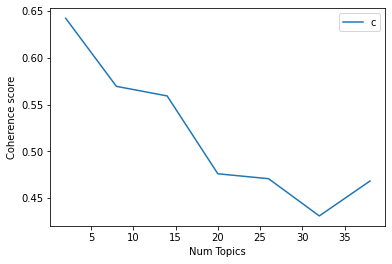

In [22]:
import matplotlib.pyplot as plt
#Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6423
Num Topics = 8  has Coherence Value of 0.5695
Num Topics = 14  has Coherence Value of 0.5593
Num Topics = 20  has Coherence Value of 0.4761
Num Topics = 26  has Coherence Value of 0.4709
Num Topics = 32  has Coherence Value of 0.4311
Num Topics = 38  has Coherence Value of 0.4684


In [24]:

# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.068*"код" + 0.038*"мати" + 0.037*"працювати" + 0.037*"тип" + '
  '0.036*"написати" + 0.028*"писати" + 0.024*"треба" + 0.016*"додатковии" + '
  '0.015*"кода" + 0.014*"помилка"'),
 (1,
  '0.099*"якии" + 0.060*"тест" + 0.034*"немати" + 0.032*"знаити" + 0.028*"наш" '
  '+ 0.026*"приклад" + 0.025*"твіи" + 0.020*"різнии" + 0.017*"можи" + '
  '0.017*"взяти"'),
 (2,
  '0.052*"завтра" + 0.044*"привіт" + 0.040*"думати" + 0.036*"може" + '
  '0.032*"хотіти" + 0.031*"давати" + 0.030*"виити" + 0.029*"завдання" + '
  '0.028*"якщо" + 0.027*"добре"'),
 (3,
  '0.034*"писати" + 0.034*"робити" + 0.029*"щось" + 0.028*"річ" + 0.025*"фаил" '
  '+ 0.023*"такии" + 0.022*"якщо" + 0.022*"лаба" + 0.016*"паш" + 0.014*"file"'),
 (4,
  '0.039*"app_web" + 0.032*"app" + 0.023*"jul_whispering" + 0.017*"саит" + '
  '0.017*"lib_python" + 0.017*"heroku_python" + 0.017*"file" + '
  '0.017*"site_packages" + 0.017*"line" + 0.015*"harmix_bot"'),
 (5,
  '0.068*"зробити" + 0.043*"сторінка" + 0.020*"добро" + 0.018*"зар

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [26]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3376,"код, мати, працювати, тип, написати, писати, т...",Наступного місяця бо зараз там якісь зміни в ...
1,1.0,0.3133,"якии, тест, немати, знаити, наш, приклад, твіи...",привіт паш могти ласок дати порад наш проект ...
2,2.0,0.3828,"завтра, привіт, думати, може, хотіти, давати, ...",привіт діма лаба зрозуміло дякувати дуже ради...
3,3.0,0.5245,"писати, робити, щось, річ, фаил, такии, якщо, ...",знайти дуже дякувати блін писати форма година...
4,4.0,0.5587,"app_web, app, jul_whispering, саит, lib_python...",мочь попробовать загрузить видео теелфон сайт...


In [27]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.to_csv(os.path.join("data", "processed_dialog_files", "subdialogs_topics.csv"))
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"код, мати, працювати, тип, написати, писати, т...",3.0,0.0224
1.0,11.0,"str, функція, стрічка, size, розмір, робити, c...",5.0,0.0373
2.0,12.0,"дуже, зараз, знати, якиись, час, цікаво, треба...",13.0,0.0970
3.0,14.0,"дуже, проект, привіт_діма, привіт, могти, gith...",5.0,0.0373
4.0,2.0,"завтра, привіт, думати, може, хотіти, давати, ...",1.0,0.0075
...,...,...,...,...
129.0,5.0,"зробити, сторінка, добро, зараз, професія, від...",NaN,NaN
130.0,5.0,"зробити, сторінка, добро, зараз, професія, від...",NaN,NaN
131.0,5.0,"зробити, сторінка, добро, зараз, професія, від...",NaN,NaN
132.0,15.0,"робити, щося, треба, дяковати, привіт_вови, ск...",NaN,NaN
